In [1]:
# @title Loading data

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Colab Notebooks/lorenz_long_x.csv'


import pandas as pd
import numpy as np

data = pd.read_csv(file_path)
data = np.array(data)

Mounted at /content/drive


In [2]:
# @title Loading optuna

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import scipy.signal
import networkx as nx
import csv

!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 19.2 MB/s eta 0:00:00


Data shape: (1048575,)


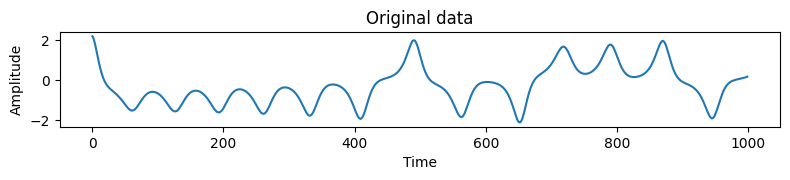

In [3]:
# @title Data reshaping

import matplotlib.pyplot as plt
import scipy.stats
import scipy.signal
import datetime
import networkx as nx
import csv


nan_indices = np.where(np.isnan(data))
data = np.delete(data, nan_indices)

# standardization
mean_value = np.mean(data)
std_dev = np.std(data)
data = (data - mean_value) / std_dev


print('Data shape:',data.shape)

#######
#Visualization

plt.figure(figsize=(8, 3))

plt.subplot(2, 1, 1)
plt.plot(data[:1000])
plt.title('Original data')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


Input gate $i_t$,

Forget gate $f_t$,

Output gate $o_t$,

$h$: Sigmoid and omit biases:
\begin{equation*}
\begin{split}
i_t&=h(W_{datain}d_t+W_{gatein}x_{t-1}),\\
f_t&=h(W_{dataforget}d_t+W_{forget}x_{t-1}),\\
o_t&=h(W_{dataout}d_t+W_{gateout}x_{t-1}),\\
%\tilde c_t&=
\end{split}
\end{equation*}
Memory cell (CEC) $c_t$:
\begin{equation*}
c_t=i_t\odot \tanh(W_{datacell}d_t+W_{cell}x_{t-1})+f_t\odot c_{t-1}
\end{equation*}
Output layer:
\begin{equation*}
x_t=o_t\odot\tanh(c_t)
\end{equation*}

 The operator $\odot$ denotes the Hadamard product (element-wise product).

In [4]:
# @title Definition of LSTM

####################
#input weight matrix
####################

def input_matrix(N_x,seed_value,input_scale,dim):

 # Separate integer and decimal portions
    seed_int_low = int(np.floor(seed_value))
    seed_int_high = int(np.ceil(seed_value))
    fraction = seed_value - seed_int_low

# Random number generation for integer part
    np.random.seed(seed_int_low)
    random_matrix_low = np.random.uniform(-input_scale, input_scale, (N_x, dim))
    np.random.seed(seed_int_high)
    random_matrix_high = np.random.uniform(-input_scale, input_scale, (N_x, dim))

# Linear interpolation allows random seed values to correspond continuously to the matrix
    interpolated_matrix = (1 - fraction) * random_matrix_low + fraction * random_matrix_high

    return interpolated_matrix

##############################
# Recurrent weight matrix
##############################

#Specify non-zero positions
def generate_random_binary_matrix(N_x, N_y, density, seed_value_binary):

    num_ones = int(N_x*N_y * density)
    matrix   = np.zeros(N_x*N_y, dtype=int)
    np.random.seed(seed_value_binary)
    ones_indices = np.random.choice(N_x*N_y, num_ones, replace=False)
    matrix[ones_indices] = 1

    return matrix.reshape((N_x, N_y))


def make_connection(N_x, density, rho,seed_value):

# Separate random seed value into integer and decimal portions
        seed_int_low  = int(np.floor(seed_value))
        seed_int_high = int(np.ceil(seed_value))
        fraction      = seed_value - seed_int_low

        random_binary_matrix_low   = generate_random_binary_matrix(N_x, N_x, density, seed_int_low)
        random_binary_matrix_high  = generate_random_binary_matrix(N_x, N_x, density, seed_int_high)
        interpolated_binary_matrix = \
         (1 - fraction) * random_binary_matrix_low + fraction * random_binary_matrix_high


# Separate integer and decimal portions
        seed_int_low  = int(np.floor(seed_value))
        seed_int_high = int(np.ceil(seed_value))
        fraction      = seed_value - seed_int_low

# Generate nonzero elements as random numbers following a uniform distribution
        rec_scale = 1.0

# Random number generation based on integer part
        np.random.seed(seed_int_low)
        random_matrix_low = np.random.uniform(-rec_scale, rec_scale, (N_x, N_x))
        np.random.seed(seed_int_high)
        random_matrix_high = np.random.uniform(-rec_scale, rec_scale, (N_x, N_x))

# Linear interpolation allows random seed values and matrices to correspond continuously
        interpolated_matrix = (1 - fraction) * random_matrix_low + fraction * random_matrix_high

        W = interpolated_binary_matrix * interpolated_matrix

        # Calculation of spectral radius
        eigv_list = np.linalg.eigh(W)[0]
        sp_radius = np.max(np.abs(eigv_list))

        # Scaling to a specified spectral radius rho
        W *= rho / sp_radius
        return W

####################
def sigmoid(x):

    #return 0.5 * (1 + np.tanh(x / 2))
    return 1 / (1 + np.exp(-x))


def Reservoir(x_in,x,W):

        x =  np.tanh(np.dot(W, x) + x_in)
        return x

def Gate(x_in,x,W):

        x =  sigmoid(np.dot(W, x) + x_in)
        return x
######################

def LSTM(x,c,x_gatein,Wgatein,x_cell,Wcell,x_forget,Wforget,x_gateout,Wgateout):

        c = Gate(x_gatein,x,Wgatein) * Reservoir(x_cell,x,Wcell) +Gate(x_forget,x,Wforget) *c
        x = Gate(x_gateout,x,Wgateout) * np.tanh(c)

        return x,c

####################
#Ridge Regression and  Output Weight Matrix
####################
def Ridge(d, x, X_XT,D_XT):

        x = np.reshape(x, (-1, 1))
        d = np.reshape(d, (-1, 1))
        X_XT += np.dot(x, np.transpose(x))
        D_XT += np.dot(d, np.transpose(x))
        return X_XT, D_XT

def get_Wout_opt(X_XT,D_XT,N_x,beta):

        #X_pseudo_inv = np.linalg.inv(X_XT + beta * np.identity(N_x))
        #Wout_opt = np.dot(D_XT, X_pseudo_inv)
        Wout_opt = np.linalg.solve((X_XT + beta * np.identity(N_x)).T, D_XT.T)
        Wout_opt=Wout_opt.T

        return Wout_opt

###################
#Definition of batch learning (convexity)
###################

def train(train_U,train_D, x,c, T_train,Wdatain,Wgatein,Wdatacell,Wcell,Wdataforget,Wforget, Wdataout,Wgateout,N_x,dim,discard_len):

    x = np.zeros(N_x)
    c = np.zeros(N_x)
    X_XT = np.zeros((N_x, N_x))
    D_XT = np.zeros((dim, N_x))


    for n in range(T_train):


            # reservoir state vector
        x,c = LSTM(x,c,np.dot(Wdatain,train_U[n,:]),Wgatein, np.dot(Wdatacell,train_U[n,:]), \
                   Wcell,np.dot(Wdataforget,train_U[n,:]),Wforget,np.dot(Wdataout,train_U[n,:]),Wgateout)

            # teacher data
        d = train_D[n,:]

        if n > discard_len:   # discard the first part of the data
            X_XT, D_XT = Ridge(d, x, X_XT, D_XT)
            #X_XT, D_XT = Ridge(d, c, X_XT, D_XT) #Peephole

    return X_XT, D_XT,x,c

########################
#induction formula for creating estimated data
########################

def run(test_U,x,c,Wdatain,Wgatein,Wdatacell,Wcell,Wdataforget,Wforget, Wdataout,Wgateout,Wout,T_test):

    Y_pred = []
    y = test_U[0,:]

    for n in range(T_test):

        x,c = LSTM(x,c,np.dot(Wdatain,y),Wgatein, np.dot(Wdatacell,y), \
                   Wcell,np.dot(Wdataforget,y),Wforget,np.dot(Wdataout,y),Wgateout)

        y_pred = np.dot(Wout, x)
        #y_pred = np.dot(Wout, c) #Peephole
        Y_pred.append(y_pred)
        y = y_pred

    return np.array(Y_pred)

###############################
#MAE
###############################
from sklearn.metrics import mean_absolute_error

def MAE(data1_in, data2_in):
    mae = mean_absolute_error(data1_in, data2_in)
    return mae

In [5]:
# @title Definition of Bayesian optimization of LSTM

%%time

from optuna.trial import FrozenTrial
from optuna.trial import TrialState
from datetime import datetime
import os

print(len(data))


################
# Objective Function Definition

def objective(trial):
    lag = trial.suggest_int("lag", 3, 10)
    dim = trial.suggest_int("dim", 3, 28)
    N_x = trial.suggest_int("N_x", Node, Node)
    beta = trial.suggest_float("beta", 0.0001, 0.0001)
    density_gate = trial.suggest_float("density_gate", 0.01, 1)
    density_res = trial.suggest_float("density_res", 0.01, 1)
    input_scale = trial.suggest_float("input_scale", 0, 1.5)
    rho_gate = trial.suggest_float("rho_gate", 0, 1.5)
    rho_res = trial.suggest_float("rho_res", 0, 1.5)
    alpha = trial.suggest_float("alpha", 0, 1)
    seed_value_datain = trial.suggest_float("seed_value_datain", 0, 100)
    seed_value_gatein = trial.suggest_float("seed_value_gatein", 0, 100)
    seed_value_datacell = trial.suggest_float("seed_value_datacell", 0, 100)
    seed_value_cell = trial.suggest_float("seed_value_cell", 0, 100)
    seed_value_dataforget = trial.suggest_float("seed_value_dataforget", 0, 100)
    seed_value_forget = trial.suggest_float("seed_value_forget", 0, 100)
    seed_value_dataout = trial.suggest_float("seed_value_dataout", 0, 100)
    seed_value_gateout = trial.suggest_float("seed_value_gateout", 0, 100)

###############

    T_0 = T_train + lag * dim
###############
#Fix various weight matrices

    Wdatain    = input_matrix(N_x,seed_value_datain,input_scale,dim)
    Wgatein    = make_connection(N_x, density_gate, rho_gate,seed_value_gatein)
    Wdatacell  = input_matrix(N_x,seed_value_datacell,input_scale,dim)
    Wcell      = make_connection(N_x, density_res, rho_res,seed_value_cell)
    Wdataforget= input_matrix(N_x,seed_value_dataforget,input_scale,dim)
    Wforget    = make_connection(N_x, density_gate, rho_gate,seed_value_forget)
    Wdataout   = input_matrix(N_x,seed_value_dataout,input_scale,dim)
    Wgateout   = make_connection(N_x, density_gate, rho_gate,seed_value_gateout)

###############
#Convert data to a delay coordinate system

    data_delay_train = np.zeros((T_train+1,dim), dtype=float)

    for i in range(dim):

        data_delay_train[:,i] = data[T_0-T_train-i*lag:T_0-i*lag+1]

# Initialization of training data

    train_U = np.zeros((T_train,dim), dtype=float)
    train_D = np.zeros((T_train,dim), dtype=float)

#Input/output of training data

    train_U = data_delay_train[:T_train,:]
    train_D = data_delay_train[1:T_train+1,:]

##The last time data of the training data output must overlap with the test data!

#Ridge
    X_XT = np.zeros((N_x, N_x))
    D_XT = np.zeros((dim, N_x))
    x_special = np.zeros(N_x)
    c_special = np.zeros(N_x)

    X_XT, D_XT,x_special,c_special = train(train_U,train_D,np.zeros(N_x),np.zeros(N_x), T_train,Wdatain,Wgatein,Wdatacell, \
                                 Wcell,Wdataforget,Wforget, Wdataout,Wgateout,N_x,dim,discard_len)

 # Generate regression weight matrix

    Wout= None
    Wout= get_Wout_opt(X_XT, D_XT,N_x,beta)

##############################
#Calculate RMSE (we can compare with TensorFlow)
##############################

    pred_D = np.zeros((T_train,dim), dtype=float)
    x = np.zeros(N_x)
    c = np.zeros(N_x)

    for n in range(T_train):

        x,c = LSTM(x,c,np.dot(Wdatain,train_U[n,:]),Wgatein, np.dot(Wdatacell,train_U[n,:]), \
                   Wcell,np.dot(Wdataforget,train_U[n,:]),Wforget,np.dot(Wdataout,train_U[n,:]),Wgateout)

        pred_D[n,:] = np.dot(Wout, x)
        #pred_D[n,:] = np.dot(Wout, c) #Peephole

    return np.sqrt(np.mean((pred_D[discard_len:]-train_D[discard_len:])**2))

1048575
CPU times: user 446 µs, sys: 41 µs, total: 487 µs
Wall time: 503 µs


In [6]:
# @title Implementation of Bayesian optimization of LSTM

%%time

n_trials = 30    # Number of times to test with optuna (generate RMSE for this number of times)
T_train = 5000   # Training period
T_test = 100     # Forecast period
Node = 70        # Node

discard_len = 10 # Number of steps not learned at the beginning (not important）

MAX_TRIALS = 8   # Repeat the same thing while shifting each one step to produce robust result


test_num = 3000  # Number of times for one test (to get one generalization error in MAE)
synchro_len=170  #Steps to generate initial hidden layer vector

#########################

mean_score  = []
score       = []

#########################
#Convert data to Implement set for each trial

for trial in range(MAX_TRIALS):
    print(f"Trial {trial + 1}/{MAX_TRIALS}")

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials)

    print("Best trial:")
    trial = study.best_trial
    print(f"  'params': {trial.params},")
    print(f"  'value': {trial.value},")

    lag  = trial.params["lag"]
    dim  = trial.params["dim"]
    N_x  = trial.params["N_x"]
    beta = trial.params["beta"]
    density_gate = trial.params["density_gate"]
    density_res  = trial.params["density_res"]
    input_scale  = trial.params["input_scale"]
    rho_gate     = trial.params["rho_gate"]
    rho_res      = trial.params["rho_res"]
    alpha        = trial.params["alpha"]
    seed_value_datain     = trial.params["seed_value_datain"]
    seed_value_gatein     = trial.params["seed_value_gatein"]
    seed_value_datacell   = trial.params["seed_value_datacell"]
    seed_value_cell       = trial.params["seed_value_cell"]
    seed_value_dataforget = trial.params["seed_value_dataforget"]
    seed_value_forget     = trial.params["seed_value_forget"]
    seed_value_dataout    = trial.params["seed_value_dataout"]
    seed_value_gateout    = trial.params["seed_value_gateout"]

###################################
##Training phase
###################################
    #Test start time

    T_0 = T_train+lag*dim

    #Fix various weight matrices

    Wdatain    = input_matrix(N_x,seed_value_datain,input_scale,dim)
    Wgatein    = make_connection(N_x, density_gate, rho_gate,seed_value_gatein)
    Wdatacell  = input_matrix(N_x,seed_value_datacell,input_scale,dim)
    Wcell      = make_connection(N_x, density_res, rho_res,seed_value_cell)
    Wdataforget= input_matrix(N_x,seed_value_dataforget,input_scale,dim)
    Wforget    = make_connection(N_x, density_gate, rho_gate,seed_value_forget)
    Wdataout   = input_matrix(N_x,seed_value_dataout,input_scale,dim)
    Wgateout   = make_connection(N_x, density_gate, rho_gate,seed_value_gateout)

    #Convert training data to a delay coordinate system

    data_delay_train = np.zeros((T_train+1,dim), dtype=float)

    for i in range(dim):

          data_delay_train[:,i] = data[T_0-T_train-i*lag:T_0-i*lag+1]  # i*lag step delayed time series

    # Initialization of training data

    train_U = np.zeros((T_train,dim), dtype=float)
    train_D = np.zeros((T_train,dim), dtype=float)

    #Input/output of training data

    train_U = data_delay_train[:T_train,:]
    train_D = data_delay_train[1:T_train+1,:]

    #Ridge
    X_XT, D_XT,x_special, c_special = train(train_U,train_D,np.zeros(N_x),np.zeros(N_x), T_train,Wdatain,Wgatein,Wdatacell, \
                                    Wcell,Wdataforget,Wforget, Wdataout,Wgateout,N_x,dim,discard_len)

    #Generate output weight matrix

    Wout= None
    Wout= get_Wout_opt(X_XT, D_XT,N_x,beta)


###################################
##Test phase
###################################


    data_delay = np.zeros((T_train+T_test+1,dim,test_num), dtype=float)

    #Convert test data to a delay coordinate system

    for t in range(test_num):

          for i in range(dim):

              data_delay[:,i,t] = data[T_0+t-T_train-i*lag
                                            :T_0+t+T_test-i*lag+1]


    # Initialization of test data

    test_Y = np.zeros((T_test,test_num))
    test_D = np.zeros((T_test,test_num))
    tentative_test_Y=np.zeros((T_test,dim,test_num))

    ##The last time data of the training data output must overlap with the test data!

    x_conti = np.zeros((N_x), dtype=float)
    c_conti = np.zeros((N_x), dtype=float)

    for t in range(test_num):


        X_XT, D_XT,x_conti,c_conti =  train(data_delay[T_train-synchro_len :T_train,:,t], \
                                    data_delay[T_train-synchro_len+1:T_train+1,:,t],np.zeros(N_x),np.zeros(N_x),synchro_len,Wdatain,Wgatein,Wdatacell, \
                                    Wcell,Wdataforget,Wforget, Wdataout,Wgateout,N_x,dim,0)

        #Predictive data generation

        tentative_test_Y[:,:,t] = run(data_delay[T_train:,:,t],x_conti,c_conti,Wdatain,Wgatein,Wdatacell, \
                                      Wcell,Wdataforget,Wforget, Wdataout,Wgateout,Wout,T_test)

        test_Y[:,t] = tentative_test_Y[:,0,t]
        test_D[:,t] = data_delay[T_train+1
                                :T_train+T_test+1,0,t]

    mae = MAE( test_Y[T_test-1,:],test_D[T_test-1,:])

    score.append(mae)
    mean_score.append(np.mean(score))

    print('MAE:',mae)
    print('Average of MAE:',np.mean(score))


[I 2025-08-25 04:01:10,589] A new study created in memory with name: no-name-1baf4901-f962-49f3-b7b0-ebd67f37a7ee


Trial 1/8


[I 2025-08-25 04:01:11,228] Trial 0 finished with value: 0.15220729829849539 and parameters: {'lag': 9, 'dim': 24, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.38748130374530376, 'density_res': 0.7165290126801013, 'input_scale': 0.48125418802743997, 'rho_gate': 0.433116264914062, 'rho_res': 1.2012199287071024, 'alpha': 0.6885322436427099, 'seed_value_datain': 96.82402170020691, 'seed_value_gatein': 62.36582591146404, 'seed_value_datacell': 0.5334179523604599, 'seed_value_cell': 96.05432949868943, 'seed_value_dataforget': 61.88546014130976, 'seed_value_forget': 2.9658471980363976, 'seed_value_dataout': 11.259468877516344, 'seed_value_gateout': 8.979186239905058}. Best is trial 0 with value: 0.15220729829849539.
[I 2025-08-25 04:01:11,988] Trial 1 finished with value: 0.055126383358790554 and parameters: {'lag': 3, 'dim': 24, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.48571313722974596, 'density_res': 0.2525561635856552, 'input_scale': 0.8642585540319915, 'rho_gate': 0.9744086668405002

Best trial:
  'params': {'lag': 5, 'dim': 7, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.27705627312813785, 'density_res': 0.07428891394390291, 'input_scale': 0.23666797666346856, 'rho_gate': 1.1050866214657833, 'rho_res': 1.4579540169152554, 'alpha': 0.32608649450413685, 'seed_value_datain': 25.9963316359773, 'seed_value_gatein': 76.80726346044091, 'seed_value_datacell': 24.982324681053964, 'seed_value_cell': 35.04613663330174, 'seed_value_dataforget': 21.13711242386129, 'seed_value_forget': 43.645019090116406, 'seed_value_dataout': 24.897487566014863, 'seed_value_gateout': 88.99041812980515},
  'value': 0.0021224511882931706,


[I 2025-08-25 04:02:39,552] A new study created in memory with name: no-name-458aca22-7636-4f99-b7a0-5f9f02d910c1


MAE: 0.3053926192844612
Average of MAE: 0.3053926192844612
Trial 2/8


[I 2025-08-25 04:02:40,594] Trial 0 finished with value: 0.007603669376016531 and parameters: {'lag': 6, 'dim': 17, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.9278445246457702, 'density_res': 0.633594827658078, 'input_scale': 0.17381263488558296, 'rho_gate': 0.3898023838275306, 'rho_res': 0.5864119175677265, 'alpha': 0.9267108892595003, 'seed_value_datain': 75.06236690769391, 'seed_value_gatein': 19.499369378641173, 'seed_value_datacell': 70.74265366812014, 'seed_value_cell': 53.64750083496873, 'seed_value_dataforget': 98.05084651912888, 'seed_value_forget': 74.82701013942034, 'seed_value_dataout': 65.46514798668684, 'seed_value_gateout': 0.7950070369953766}. Best is trial 0 with value: 0.007603669376016531.
[I 2025-08-25 04:02:41,205] Trial 1 finished with value: 0.016241785198832823 and parameters: {'lag': 6, 'dim': 15, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.22510138214795866, 'density_res': 0.1711069078188215, 'input_scale': 0.4404345714700047, 'rho_gate': 0.9760370159570062

Best trial:
  'params': {'lag': 3, 'dim': 3, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.6924254998281867, 'density_res': 0.9765889170563529, 'input_scale': 0.950600798722556, 'rho_gate': 0.4169649306953731, 'rho_res': 1.039746106725913, 'alpha': 0.005342205980723103, 'seed_value_datain': 42.530150429825184, 'seed_value_gatein': 56.45925654559285, 'seed_value_datacell': 71.25488138877041, 'seed_value_cell': 98.10297995802907, 'seed_value_dataforget': 0.14229775815542567, 'seed_value_forget': 90.70217506744436, 'seed_value_dataout': 39.39200340691886, 'seed_value_gateout': 98.5555274457895},
  'value': 0.002107219221382742,


[I 2025-08-25 04:03:53,807] A new study created in memory with name: no-name-3e4d1e30-1008-4045-9622-9eed14756ebb


MAE: 0.6326273874890852
Average of MAE: 0.46901000338677323
Trial 3/8


[I 2025-08-25 04:03:54,420] Trial 0 finished with value: 0.002339346817933632 and parameters: {'lag': 5, 'dim': 11, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.7063125076609885, 'density_res': 0.17386225826327398, 'input_scale': 0.11254137002377695, 'rho_gate': 0.9013157143686814, 'rho_res': 0.7934264618783715, 'alpha': 0.23064584257176923, 'seed_value_datain': 58.902923103918546, 'seed_value_gatein': 96.11399660585107, 'seed_value_datacell': 22.396901748009213, 'seed_value_cell': 70.8871681941573, 'seed_value_dataforget': 31.525741308277222, 'seed_value_forget': 13.303638885294845, 'seed_value_dataout': 6.8473542345445555, 'seed_value_gateout': 16.08031030355017}. Best is trial 0 with value: 0.002339346817933632.
[I 2025-08-25 04:03:55,011] Trial 1 finished with value: 0.008087364980192885 and parameters: {'lag': 3, 'dim': 19, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.6912373051394392, 'density_res': 0.8517849434035133, 'input_scale': 0.39016479283436994, 'rho_gate': 0.68694864945

Best trial:
  'params': {'lag': 4, 'dim': 5, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.6834552500410702, 'density_res': 0.8141367857544238, 'input_scale': 0.7079423804104322, 'rho_gate': 0.938654523731477, 'rho_res': 0.6009953255666545, 'alpha': 0.09471811805526228, 'seed_value_datain': 50.12249370539709, 'seed_value_gatein': 63.43144579332747, 'seed_value_datacell': 55.481413491883316, 'seed_value_cell': 75.32971280118943, 'seed_value_dataforget': 43.50885745467527, 'seed_value_forget': 37.153310866352115, 'seed_value_dataout': 71.51265418340503, 'seed_value_gateout': 38.166623425456265},
  'value': 0.0021359918386251115,


[I 2025-08-25 04:05:06,843] A new study created in memory with name: no-name-6ea97035-f99f-47a6-b10f-c0cdf2fe95f3


MAE: 0.2777443454703627
Average of MAE: 0.40525478408130305
Trial 4/8


[I 2025-08-25 04:05:07,447] Trial 0 finished with value: 0.07385191738800059 and parameters: {'lag': 7, 'dim': 21, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.7686353499188326, 'density_res': 0.8176198108690137, 'input_scale': 0.4907965782574178, 'rho_gate': 0.990890242745161, 'rho_res': 0.805198019913679, 'alpha': 0.7553104017273286, 'seed_value_datain': 97.66879905972736, 'seed_value_gatein': 87.91034333646056, 'seed_value_datacell': 24.349721745832642, 'seed_value_cell': 98.64059234910414, 'seed_value_dataforget': 13.446380527641576, 'seed_value_forget': 64.37815726015252, 'seed_value_dataout': 18.798749702446514, 'seed_value_gateout': 79.83637984183773}. Best is trial 0 with value: 0.07385191738800059.
[I 2025-08-25 04:05:08,094] Trial 1 finished with value: 0.003403394807273582 and parameters: {'lag': 8, 'dim': 10, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.050936928015487055, 'density_res': 0.5159785354870415, 'input_scale': 0.18663451114344493, 'rho_gate': 1.2347906399337418,

Best trial:
  'params': {'lag': 3, 'dim': 8, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.24242098788494745, 'density_res': 0.47707402730792114, 'input_scale': 0.31003611506145284, 'rho_gate': 0.2778836789447609, 'rho_res': 0.22776180472284202, 'alpha': 0.2400949540052055, 'seed_value_datain': 35.137199129344026, 'seed_value_gatein': 12.361537654891652, 'seed_value_datacell': 98.89815294477411, 'seed_value_cell': 42.599478798054115, 'seed_value_dataforget': 6.877324073134774, 'seed_value_forget': 30.366997447763236, 'seed_value_dataout': 75.97539543839972, 'seed_value_gateout': 94.43816543515874},
  'value': 0.001974646209912112,


[I 2025-08-25 04:06:23,754] A new study created in memory with name: no-name-09dd3300-5cc7-4481-a619-c32442fd1059


MAE: 0.1864556534587837
Average of MAE: 0.35055500142567325
Trial 5/8


[I 2025-08-25 04:06:24,353] Trial 0 finished with value: 0.08349724374827651 and parameters: {'lag': 5, 'dim': 21, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.6028437849550385, 'density_res': 0.8060412256622717, 'input_scale': 0.7542009807108281, 'rho_gate': 1.0305512370933334, 'rho_res': 1.4407456055908607, 'alpha': 0.16009603556437435, 'seed_value_datain': 11.53934462973364, 'seed_value_gatein': 91.22992140332875, 'seed_value_datacell': 34.86251095571795, 'seed_value_cell': 69.92805915648434, 'seed_value_dataforget': 2.945478892897413, 'seed_value_forget': 41.916307877127565, 'seed_value_dataout': 54.22109391142747, 'seed_value_gateout': 68.39087188022224}. Best is trial 0 with value: 0.08349724374827651.
[I 2025-08-25 04:06:24,966] Trial 1 finished with value: 0.17175731524210475 and parameters: {'lag': 7, 'dim': 27, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.6425904959931253, 'density_res': 0.9171218581250449, 'input_scale': 0.8195160284573699, 'rho_gate': 1.389027941800363, 'rh

Best trial:
  'params': {'lag': 3, 'dim': 10, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.029608087558272475, 'density_res': 0.39130024834899024, 'input_scale': 0.2906659789113356, 'rho_gate': 0.4055123839470772, 'rho_res': 0.9480723129947469, 'alpha': 0.0792299116845866, 'seed_value_datain': 32.89830057716778, 'seed_value_gatein': 7.552720897132156, 'seed_value_datacell': 53.85848592343577, 'seed_value_cell': 82.59556067390683, 'seed_value_dataforget': 28.20372959872226, 'seed_value_forget': 52.232194428052054, 'seed_value_dataout': 29.62751588359881, 'seed_value_gateout': 4.980826946020819},
  'value': 0.001977616611080153,


[I 2025-08-25 04:07:39,424] A new study created in memory with name: no-name-75bee53e-66c2-4fb1-8819-48b2443472a7


MAE: 0.0950773680498465
Average of MAE: 0.2994594747505079
Trial 6/8


[I 2025-08-25 04:07:40,335] Trial 0 finished with value: 0.09239738440394643 and parameters: {'lag': 8, 'dim': 12, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.873470621178239, 'density_res': 0.9945531055089194, 'input_scale': 1.1844750384325868, 'rho_gate': 0.6190989324468856, 'rho_res': 0.9374860807652842, 'alpha': 0.6211151568392222, 'seed_value_datain': 66.12701627903121, 'seed_value_gatein': 19.02148472301096, 'seed_value_datacell': 77.8838009464549, 'seed_value_cell': 52.47552998141528, 'seed_value_dataforget': 18.76011666042117, 'seed_value_forget': 59.64485612133005, 'seed_value_dataout': 25.733548765551472, 'seed_value_gateout': 8.768220723280695}. Best is trial 0 with value: 0.09239738440394643.
[I 2025-08-25 04:07:41,229] Trial 1 finished with value: 0.021170719585524207 and parameters: {'lag': 10, 'dim': 5, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.7297752837937199, 'density_res': 0.9027718693565795, 'input_scale': 1.2320438312578872, 'rho_gate': 1.1709874005511736, 'rho

Best trial:
  'params': {'lag': 3, 'dim': 14, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.12853520652139258, 'density_res': 0.9531986494651514, 'input_scale': 0.18019668806461303, 'rho_gate': 0.7061683153631051, 'rho_res': 1.3082622544199456, 'alpha': 0.35662688000314446, 'seed_value_datain': 63.27089759135056, 'seed_value_gatein': 50.32761686541504, 'seed_value_datacell': 24.14137781645155, 'seed_value_cell': 69.08645672381657, 'seed_value_dataforget': 26.669795901917404, 'seed_value_forget': 14.256313761787364, 'seed_value_dataout': 71.94648106559065, 'seed_value_gateout': 36.48015903040562},
  'value': 0.00203556723310829,


[I 2025-08-25 04:08:59,945] A new study created in memory with name: no-name-3ee7857a-431d-4da8-89b8-95a54a10b495


MAE: 0.1997868988344267
Average of MAE: 0.28284737876449434
Trial 7/8


[I 2025-08-25 04:09:00,552] Trial 0 finished with value: 0.02762277735743138 and parameters: {'lag': 10, 'dim': 11, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.03585507195678258, 'density_res': 0.8428658152441044, 'input_scale': 0.4418436955879389, 'rho_gate': 1.4263389066094248, 'rho_res': 0.6884688276490738, 'alpha': 0.5680502377037996, 'seed_value_datain': 26.159454230921796, 'seed_value_gatein': 21.33019864047515, 'seed_value_datacell': 2.5565176621389796, 'seed_value_cell': 14.945530672940134, 'seed_value_dataforget': 82.49228403392718, 'seed_value_forget': 45.874710221108394, 'seed_value_dataout': 59.042698722889874, 'seed_value_gateout': 97.67149248827492}. Best is trial 0 with value: 0.02762277735743138.
[I 2025-08-25 04:09:01,172] Trial 1 finished with value: 0.0022217093586374037 and parameters: {'lag': 3, 'dim': 6, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.9847872995365193, 'density_res': 0.5106815012379898, 'input_scale': 0.5853818005626673, 'rho_gate': 0.77483696759647

Best trial:
  'params': {'lag': 3, 'dim': 3, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.574052944001282, 'density_res': 0.8747065810833512, 'input_scale': 0.7793374242062182, 'rho_gate': 0.3757331992965457, 'rho_res': 0.6270783421159053, 'alpha': 0.9031638647548298, 'seed_value_datain': 63.543559901461165, 'seed_value_gatein': 0.8566978706181193, 'seed_value_datacell': 90.1713634713905, 'seed_value_cell': 12.920269499703547, 'seed_value_dataforget': 6.700922240225147, 'seed_value_forget': 81.68649115153923, 'seed_value_dataout': 46.48316723788896, 'seed_value_gateout': 3.8098286956862712},
  'value': 0.0020710584024433345,


[I 2025-08-25 04:10:15,893] A new study created in memory with name: no-name-7aacf91f-d956-4ea1-a8ca-665880d91f82


MAE: 0.48154741551734365
Average of MAE: 0.3112330983006157
Trial 8/8


[I 2025-08-25 04:10:16,528] Trial 0 finished with value: 0.06077255887587812 and parameters: {'lag': 4, 'dim': 22, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.8867448777230558, 'density_res': 0.8406390950305103, 'input_scale': 0.7635005348970838, 'rho_gate': 0.5900281963860753, 'rho_res': 0.7927562331987155, 'alpha': 0.5748597799513177, 'seed_value_datain': 62.99168743039068, 'seed_value_gatein': 79.23340457361371, 'seed_value_datacell': 64.88652045634558, 'seed_value_cell': 43.67329537882569, 'seed_value_dataforget': 70.40376377392276, 'seed_value_forget': 41.40267008971538, 'seed_value_dataout': 66.45617191601625, 'seed_value_gateout': 21.21507678229274}. Best is trial 0 with value: 0.06077255887587812.
[I 2025-08-25 04:10:17,146] Trial 1 finished with value: 0.14100066617076149 and parameters: {'lag': 5, 'dim': 24, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.4682200970355252, 'density_res': 0.15935298690446534, 'input_scale': 1.2613861517234537, 'rho_gate': 1.321189813695983, 'rho

Best trial:
  'params': {'lag': 3, 'dim': 3, 'N_x': 70, 'beta': 0.0001, 'density_gate': 0.7139045009952516, 'density_res': 0.5899767523321775, 'input_scale': 0.7954541447472842, 'rho_gate': 0.5169497334515527, 'rho_res': 1.4016433892283897, 'alpha': 0.4506277516131059, 'seed_value_datain': 23.027142733555102, 'seed_value_gatein': 12.514143398359693, 'seed_value_datacell': 14.36804632671911, 'seed_value_cell': 86.8373269711352, 'seed_value_dataforget': 34.193511482387365, 'seed_value_forget': 57.28616155447158, 'seed_value_dataout': 30.054458937231544, 'seed_value_gateout': 9.598130711691121},
  'value': 0.002031569256498395,
MAE: 0.6023675444306991
Average of MAE: 0.3476249040668761
CPU times: user 10min 23s, sys: 4.76 s, total: 10min 27s
Wall time: 10min 18s


Average of MAE: 0.3476249040668761


/tmp/ipython-input-4054014136.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()#loc='lower right')


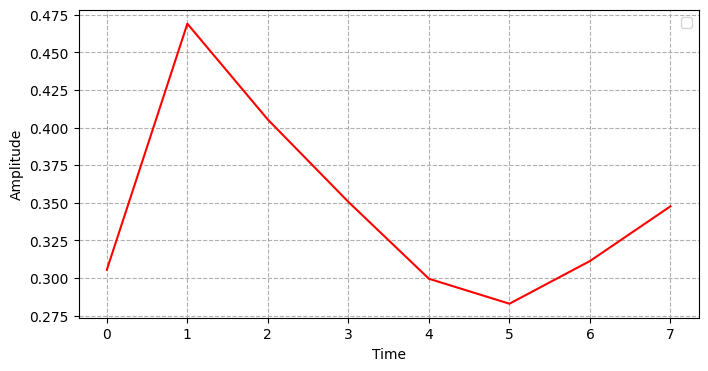

In [7]:
# @title Result of LSTM prediction

mean_score = np.array(mean_score)

import matplotlib.pyplot as plt


print('Average of MAE:',mean_score[MAX_TRIALS-1])

# Running Test Predictions
plt.figure(figsize=(8, 4))
plt.plot(mean_score, color = "red")
plt.legend()#loc='lower right')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(which='major', linestyle='--', axis='both')

plt.show()

MAE(the last trial): 0.6023675444306991
forecast period: 100


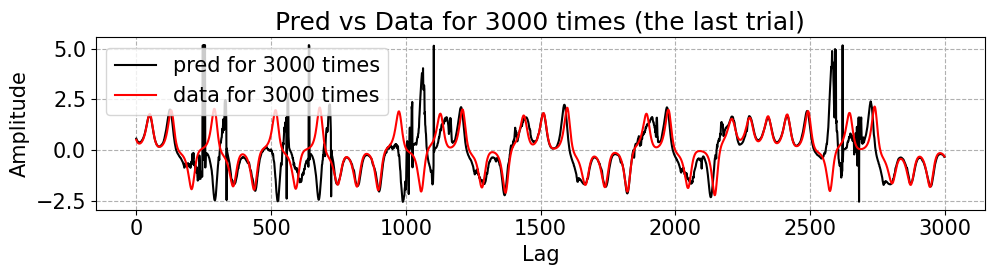

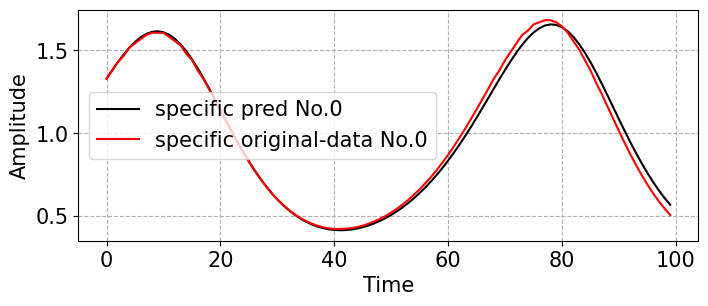

In [8]:
# @title Visualization (only the last trial)

print("MAE(the last trial):", mae)
print("forecast period:", T_test)

fig = plt.figure(figsize=(10,3), dpi=100)
plt.rcParams["font.size"] = 15
plt.grid(which='major', linestyle='--', axis='both')
plt.xlabel("Lag")
plt.ylabel("Amplitude")
plt.title(f"Pred vs Data for {test_num} times (the last trial)")
plt.plot(test_Y[T_test-1,:], color="black", label=f"pred for {test_num} times")
plt.plot(test_D[T_test-1,:], color = "red",label=f"data for {test_num} times")
plt.legend()#loc='lower right')
plt.tight_layout()
plt.show()

#####################
T_fix = 0
#####################

# Running Test Predictions
plt.figure(figsize=(8, 3))
plt.plot(test_Y[:,T_fix], color = "black",label=f"specific pred No.{T_fix}")
plt.plot(test_D[:,T_fix], color = "red",label=f"specific original-data No.{T_fix}")
plt.legend()#loc='lower right')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(which='major', linestyle='--', axis='both')

plt.show()